# Using Box Office Data as a Predictor for Movie Theatre Stocks


## Installing and Loading Neccesary Packages

In [ ]:
install.packages("rvest") #A Web-Scrapping Package
install.packages("magrittr")
install.packages("stringr")
install.packages("quantmod")
install.packages("RMySQL")
install.packages("dplyr")

library(rvest)
library(magrittr)
library(stringr)
library(quantmod)
library(RMySQL)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




  ## Scrapping website boxofficemojo for weekly revenue

In [ ]:
boxoffice = data.frame(year = 0, week_number = 0, date = as.Date('1990-01-01'), weekly_rev = 0)
years_looped = 0

for (nyear in 2018:2021) {
  #1. Load the website boxofficemojo
  url = paste("https://www.boxofficemojo.com/weekly/by-year/", nyear, "/", sep = "")
  
  webpage <- read_html(url)

  #2. Count the number of observations/week available
  for (i in 2:54) {
    html_node(webpage, paste("tr:nth-child(", i ,") .mojo-estimatable", sep = "")) %>% html_text() -> temp 
    if (is.na(temp)) {
      break 
    }
  }
  
  #3. Get weekly revenue
  num = i - 2
  for (n in 1:num) {
    html_node(webpage, paste("tr:nth-child(", num + 2 - n ,") .mojo-estimatable", sep = "")) %>% html_text() -> temp 
    assign(paste("week", n, "_rev", sep = ""), as.numeric(str_remove_all(temp, "[$,]")))
  }
  
  #4. Load data into data.frame
  for (n in 1:num) {
    boxoffice[n+years_looped*52, 1] = nyear
    boxoffice[n+years_looped*52, 2] = n
    boxoffice[n+years_looped*52, 3] = get_date(n, nyear, start = 5)
    boxoffice[n+years_looped*52, 4] = eval(parse(text = paste("week", n, "_rev", sep = "")))
  }
  years_looped = years_looped +1
}

In [ ]:
head(boxoffice)

,year,week_number,date,weekly_rev
,<dbl>,<dbl>,<date>,<dbl>
1,2018,1,2017-12-29,221132888
2,2018,2,2018-01-05,234295238
3,2018,3,2018-01-12,184047126
4,2018,4,2018-01-19,187471873
5,2018,5,2018-01-26,129767460
6,2018,6,2018-02-02,201409377


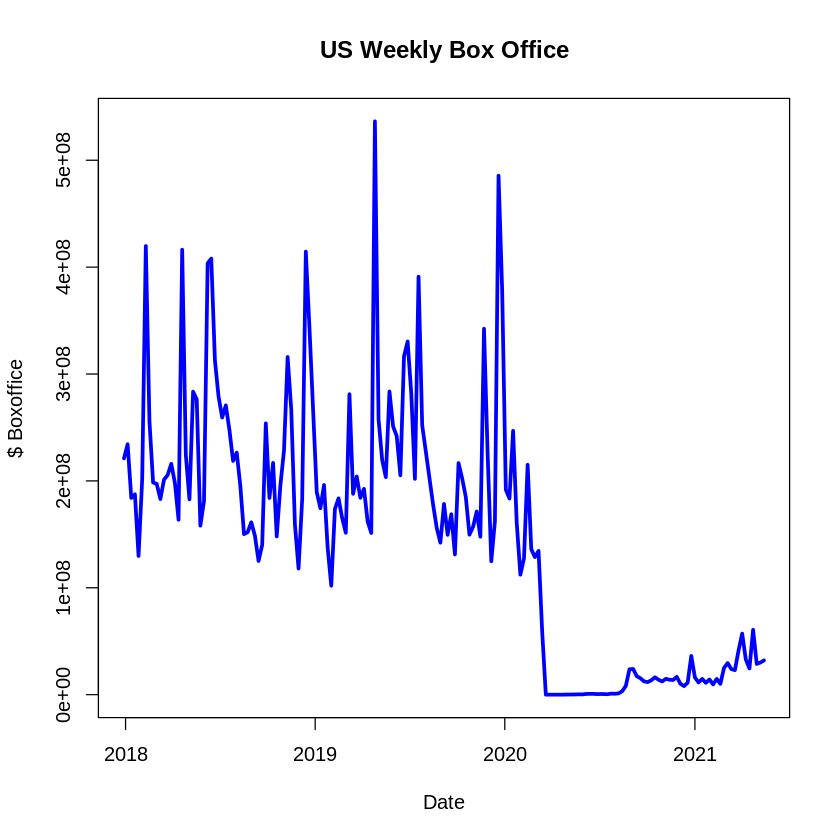

In [ ]:
plot(x = boxoffice$date, y = boxoffice$weekly_rev, xlab = 'Date', ylab = '$ Boxoffice', type = 'l', col = 'blue', lwd = 3, main = 'US Weekly Box Office')

## Export data.frame into SQL DB

In [ ]:
queryMySQL = function(statement) {
  con = dbConnect(MySQL(), host = "147.8.122.231", user = "fina_4359_u3548379", password = "856e7")
  response = dbGetQuery(con,statement)
  dbDisconnect(con)

  return(response)  
}

queryMySQL("show tables in writeable_fina_4359_u3548379")

#lapply(dbListConnections(dbDriver( drv = "MySQL")), dbDisconnect)

Tables_in_writeable_fina_4359_u3548379
<chr>
JETS
TSA
alexarank_daily_by_individual_companies
alexarank_daily_cummulative
alexarank_weekly_cummulative
google_trends_weekly_data
visits


In [ ]:
con = dbConnect(MySQL(), host = "147.8.122.231", user = "fina_4359_u3548379", password = "856e7", dbname = "writeable_fina_4359_u3548379")
dbWriteTable(conn = con, name = "Boxoffice_weekly_revenue", boxoffice[,c(1,3,4)], overwrite = TRUE) 
# dbWriteTable(conn = con, name = "JETS", regression_data_weekly[,c(1,2,4:5)], overwrite = TRUE) 

queryMySQL("select * from writeable_fina_4359_u3548379.Boxoffice_weekly_revenue order by date asc limit 10")
# queryMySQL("select * from writeable_fina_4359_u3548379.JETS order by date asc limit 10")

[1] TRUE

row_names,year,date,weekly_rev
<chr>,<dbl>,<chr>,<dbl>
1,2018,2017-12-29,221132888
2,2018,2018-01-05,234295238
3,2018,2018-01-12,184047126
4,2018,2018-01-19,187471873
5,2018,2018-01-26,129767460
6,2018,2018-02-02,201409377
7,2018,2018-02-09,419745271
8,2018,2018-02-16,255715632
9,2018,2018-02-23,198506984


## Downloading Individual Movie Stock Data

In [ ]:
options("getSymbols.warning4.0"=FALSE)
tickers = c("AMC", "IMAX", "CNK")
chosen = tickers[1]

getSymbols(chosen)
ticker = eval(parse(text=chosen))[,-c(1:5)]
colnames(ticker)[1] = "price"

adj_JETS = data.frame(date = as.Date("1990-01-01"), price = 0)
for (num_row in 1:nrow(ticker)) {
  adj_JETS[num_row,1] = index(ticker)[num_row]
  adj_JETS[num_row,2] = ticker[num_row,1]
}

tail(adj_JETS)

[1] "AMC"

,date,price
,<date>,<dbl>
1866,2021-05-18,14.03
1867,2021-05-19,12.64
1868,2021-05-20,12.55
1869,2021-05-21,12.08
1870,2021-05-24,13.68
1871,2021-05-25,16.41


## Downloading S&P 500 Data

In [ ]:
getSymbols("^GSPC")

SPX = GSPC[,-c(1:5)]
colnames(SPX)[1] = "price"

adj_SPX = data.frame(date = as.Date("1990-01-01"), price = 0)
for (num_row in 1:nrow(SPX)) {
  adj_SPX[num_row,1] = index(SPX)[num_row]
  adj_SPX[num_row,2] = SPX[num_row,1]
}

tail(adj_SPX)

[1] "^GSPC"

,date,price
,<date>,<dbl>
3619,2021-05-18,4127.83
3620,2021-05-19,4115.68
3621,2021-05-20,4159.12
3622,2021-05-21,4155.86
3623,2021-05-24,4197.05
3624,2021-05-25,4188.13


## Downloading Risk-Free Rate (10Y US Govn't Treasuries Yield)

In [ ]:
getSymbols("DGS10", src = "FRED")

rf = data.frame(date = as.Date("1990-01-01"), yield = 0)


for (num_row in 1:nrow(DGS10)) {
  rf[num_row,1] = index(DGS10)[num_row]
  rf[num_row,2] = DGS10[num_row,1]
}

#Linearly Interpolating Missing Value
  
for (num_row in 2:nrow(rf)) {
  if (is.na(rf[num_row,2]) == TRUE) {
    rf[num_row,2] = (rf[num_row-1,2] + rf[num_row+1,2])/2
  }
}

head(rf)

[1] "DGS10"

,date,yield
,<date>,<dbl>
1,1962-01-02,4.06
2,1962-01-03,4.03
3,1962-01-04,3.99
4,1962-01-05,4.02
5,1962-01-08,4.03
6,1962-01-09,4.05


## Merging Daily Box Office Data & Individual Stock Data

In [ ]:
boxoffice = boxoffice %>% select(date, weekly_rev)
head(boxoffice)

,date,weekly_rev
,<date>,<dbl>
1,2017-12-29,221132888
2,2018-01-05,234295238
3,2018-01-12,184047126
4,2018-01-19,187471873
5,2018-01-26,129767460
6,2018-02-02,201409377


In [ ]:
merge(adj_JETS, boxoffice, by = "date", all.x = TRUE) %>% merge(adj_SPX, by = "date", all.x = TRUE) %>% merge(rf, by = "date", all.x = TRUE) -> regression_data

colnames(regression_data)[c(2,4)] = c(paste(chosen,"_price",sep=""), "SPX")

head(regression_data)

,date,AMC_price,weekly_rev,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013-12-18,13.59341,NA,1810.65,2.89
2,2013-12-19,14.01776,NA,1809.60,2.94
3,2013-12-20,14.15441,NA,1818.32,2.89
4,2013-12-23,14.19756,NA,1827.99,2.94
5,2013-12-24,14.04653,NA,1833.32,2.99
6,2013-12-26,14.22633,NA,1842.02,3.00


## Transform Daily Data into Weekly Data

In [ ]:
temp_JETS <- as.xts(regression_data[paste(chosen,"_price",sep="")], order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") 
temp_JETS <- temp_JETS["2017-12-29/2021"]

temp_SPX <- as.xts(regression_data$SPX, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") 
temp_SPX <- temp_SPX["2017-12-29/2021"]

temp_yield <- as.xts(regression_data$yield, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof")
temp_yield <- temp_yield["2017-12-29/2021"]

temp_g_trends <- as.xts(boxoffice$weekly_rev, order.by = as.Date(boxoffice$date)) %>% to.weekly(indexAt = "startof")
temp_g_trends <- temp_g_trends["2017-12-29/2021"]


regression_data_weekly = data.frame(date = as.Date("1990-01-01"), placeholder_name = 0, Box_Office_Weekly_Revenue =0,  SPX = 0, yield = 0)

for (i in 1:nrow(temp_g_trends)) {
  regression_data_weekly[i,1] = index(temp_g_trends)[i]  
  regression_data_weekly[i,2] = temp_JETS[i,4]
  regression_data_weekly[i,3] = temp_g_trends[i,1]
  regression_data_weekly[i,4] = temp_SPX[i,1]
  regression_data_weekly[i,5] = temp_yield[i,1]
}

if (Sys.Date() >= regression_data_weekly[nrow(temp_g_trends),1]) {
  regression_data_weekly <- regression_data_weekly[-nrow(temp_g_trends),]
}

names(regression_data_weekly)[names(regression_data_weekly) == "placeholder_name"] <- paste("AMC","_closing_price",sep="")

head(regression_data_weekly,20)

#Consider trying 2020-04-06

Warning message in to.period(x, "weeks", name = name, ...):
“missing values removed from data”


,date,AMC_closing_price,Box_Office_Weekly_Revenue,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,2017-12-29,11.48981,221132888,2695.81,2.46
2,2018-01-05,11.77502,234295238,2747.71,2.49
3,2018-01-12,10.75642,184047126,2776.42,2.54
4,2018-01-19,10.47121,187471873,2832.97,2.66
5,2018-01-26,11.36758,129767460,2853.53,2.70
6,2018-02-02,10.96014,201409377,2648.94,2.77
7,2018-02-09,11.73427,419745271,2656.00,2.86
8,2018-02-16,12.10097,255715632,2716.26,2.88
9,2018-02-23,12.83436,198506984,2779.60,2.86


# Preparing for Regression

In [ ]:
to_regress = data.frame(date = as.Date("1990-01-01"), JETS_weekly_return = 0, Box_Office_Weekly_Revenue =0, SPX_weekly_return = 0,JETS_weekly_excess_return=0,	SPX_weekly_excess_return =0, JETS_rebased = 0, Box_Office_Weekly_Revenue_Rebased=0, SPX_rebased=0)
for(i in 1:nrow(regression_data_weekly))
{
   if (i == 1) {
      to_regress[i,1] = regression_data_weekly[i,1]
      to_regress[i,7] = 1
      to_regress[i,8] = 1
      to_regress[i,9] = 1
    } 
    else{
 to_regress[i,1] = regression_data_weekly[i,1]
 to_regress[i,2] = (regression_data_weekly[i,2]-regression_data_weekly[i-1,2])/regression_data_weekly[i-1,2]
 to_regress[i,3] = (regression_data_weekly[i,3]-regression_data_weekly[i-1,3])/regression_data_weekly[i-1,3]
 to_regress[i,4] = (regression_data_weekly[i,4]-regression_data_weekly[i-1,4])/regression_data_weekly[i-1,4]
 to_regress[i,5] = (regression_data_weekly[i,2]-regression_data_weekly[i-1,2])/regression_data_weekly[i-1,2] - regression_data_weekly[i,5]/52/100
 to_regress[i,6] = (regression_data_weekly[i,4]-regression_data_weekly[i-1,4])/regression_data_weekly[i-1,4] - regression_data_weekly[i,5]/52/100
 to_regress[i,7] = to_regress[i-1,7] * (1 + to_regress[i,2])
 to_regress[i,8] = to_regress[i-1,8] * (1 + to_regress[i,3])
 to_regress[i,9] = to_regress[i-1,9] * (1 + to_regress[i,4])
    }
}
names(to_regress)[names(to_regress) == "JETS_weekly_return"] <- paste(chosen,"_weekly_return",sep="")
names(to_regress)[names(to_regress) == "JETS_weekly_excess_return"] <- paste(chosen,"_weekly_excess_return",sep="")
names(to_regress)[names(to_regress) == "JETS_rebased"] <- paste(chosen,"_rebased",sep="")
tail(to_regress,20)


,date,AMC_weekly_return,Box_Office_Weekly_Revenue,SPX_weekly_return,AMC_weekly_excess_return,SPX_weekly_excess_return,AMC_rebased,Box_Office_Weekly_Revenue_Rebased,SPX_rebased
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
156,2020-12-25,-0.103571429,2.24592009,0.0130034440,-0.103754121,0.0128207517,0.2184545,0.16379222,1.370616
157,2021-01-01,-0.155378486,-0.55465794,0.0109448069,-0.155559255,0.0107640377,0.1845114,0.07294356,1.385617
158,2021-01-08,0.009433962,-0.29264757,-0.0092923317,0.009255116,-0.0094711778,0.1862520,0.05159681,1.372741
159,2021-01-15,0.088785047,0.29487795,0.0267413043,0.088563893,0.0265201504,0.2027884,0.06681157,1.409450
160,2021-01-22,0.506437768,-0.25025810,-0.0001842807,0.506226230,-0.0003958192,0.3054881,0.05009143,1.409190
161,2021-01-29,2.777777778,0.28295376,0.0148595772,2.777575855,0.0146576541,1.1540663,0.06426499,1.430130
162,2021-02-05,-0.484917044,-0.32292441,-0.0211394001,-0.485126659,-0.0213490155,0.5944399,0.04351226,1.399898
163,2021-02-12,-0.181551977,0.53061399,0.0375557061,-0.181780823,0.0373268599,0.4865181,0.06660047,1.452473
164,2021-02-19,0.019677996,-0.31341511,0.0043416189,0.019427996,0.0040916189,0.4960918,0.04572688,1.458779


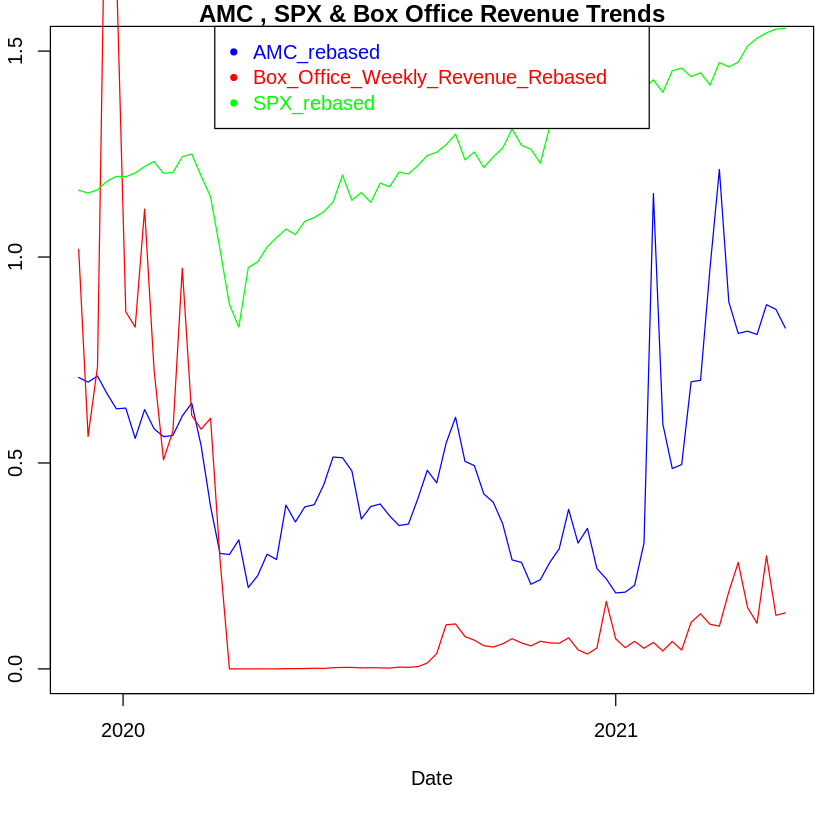

In [ ]:
par(mar=c(6.1, 2.1, 1.1, 1.1),xpd=TRUE)
plot(x = to_regress[100:175,1], y = to_regress[100:175,7], type = "l", col = "blue", ylim = c(0,1.5), xlab = "Date", ylab = "", main = paste(chosen,", SPX & Box Office Revenue Trends"))
lines(x = to_regress[100:175,1], y = to_regress[100:175,8], type = "l", col = "red")
lines(x = to_regress[100:175,1], y = to_regress[100:175,9], type = "l", col = "green")
legend("top",
        legend = colnames(to_regress)[7:9], 
        col = c("blue", "red", "green"),  
        pch = 20,
        bty = "o", 
        text.col = c("blue", "red", "green"), 
        inset = c(-0.7, 0.0))

In [ ]:
head(to_regress)

,date,AMC_weekly_return,Box_Office_Weekly_Revenue,SPX_weekly_return,AMC_weekly_excess_return,SPX_weekly_excess_return,AMC_rebased,Box_Office_Weekly_Revenue_Rebased,SPX_rebased
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2017-12-29,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,1.0000000,1.0000000,1.0000000
2,2018-01-05,0.02482278,0.05952235,0.019252062,0.02434394,0.018773216,1.0248228,1.0595224,1.0192521
3,2018-01-12,-0.08650527,-0.21446493,0.010448687,-0.08699373,0.009960225,0.9361702,0.8322920,1.0299019
4,2018-01-19,-0.02651506,0.01860799,0.020367974,-0.02702660,0.019856436,0.9113476,0.8477792,1.0508789
5,2018-01-26,0.08560320,-0.30780304,0.007257422,0.08508397,0.006738191,0.9893619,0.5868302,1.0585056
6,2018-02-02,-0.03584246,0.55207921,-0.071697191,-0.03637516,-0.072229883,0.9539007,0.9108070,0.9826137


## Regressing Arithmetic Weekly Individual Stock Returns - CAPM


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48885 -0.07144 -0.01935  0.04023  2.75666 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)      0.01392    0.01869   0.745    0.458
to_regress[, 6]  0.47750    0.62543   0.763    0.446

Residual standard error: 0.2463 on 173 degrees of freedom
Multiple R-squared:  0.003358,	Adjusted R-squared:  -0.002403 
F-statistic: 0.5829 on 1 and 173 DF,  p-value: 0.4462


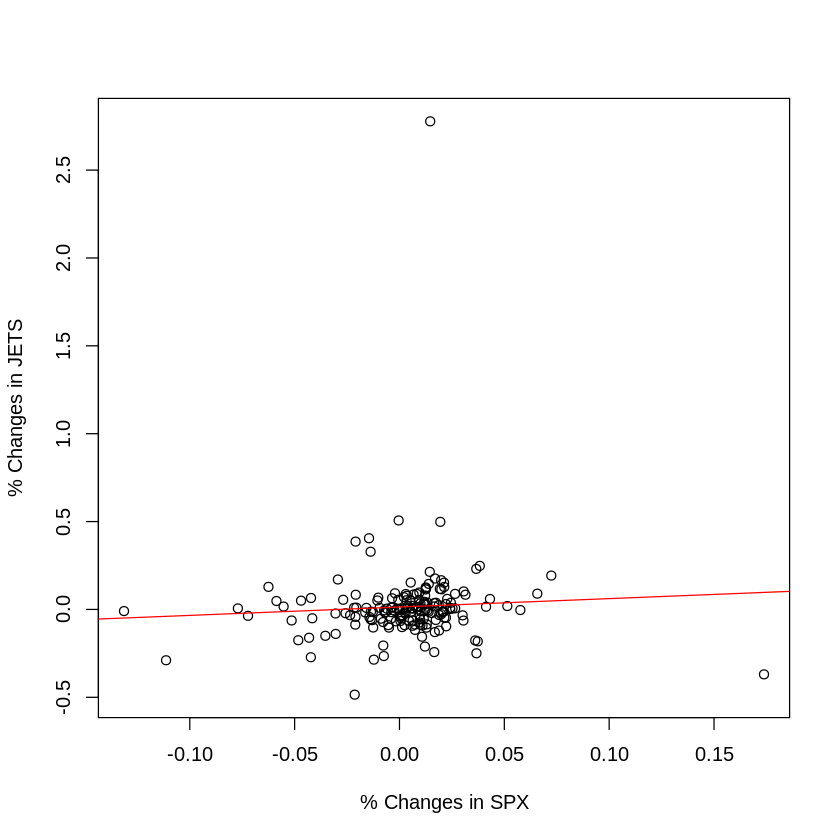

In [ ]:
lm_result_1 = lm(to_regress[,5] ~ to_regress[,6]) # i.e. CAPM
summary(lm_result_1)

plot(to_regress[,5] ~ to_regress[,6], xlab = "% Changes in SPX", ylab = "% Changes in JETS")
abline(lm_result_1, col="red")

## Regressing Arithmetic Weekly Individual Stock Return - Box Office Data


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 3])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47739 -0.07030 -0.00555  0.04206  2.75684 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)  
(Intercept)     0.007437   0.018923   0.393    0.695  
to_regress[, 3] 0.047004   0.025121   1.871    0.063 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2443 on 173 degrees of freedom
Multiple R-squared:  0.01984,	Adjusted R-squared:  0.01417 
F-statistic: 3.501 on 1 and 173 DF,  p-value: 0.06301


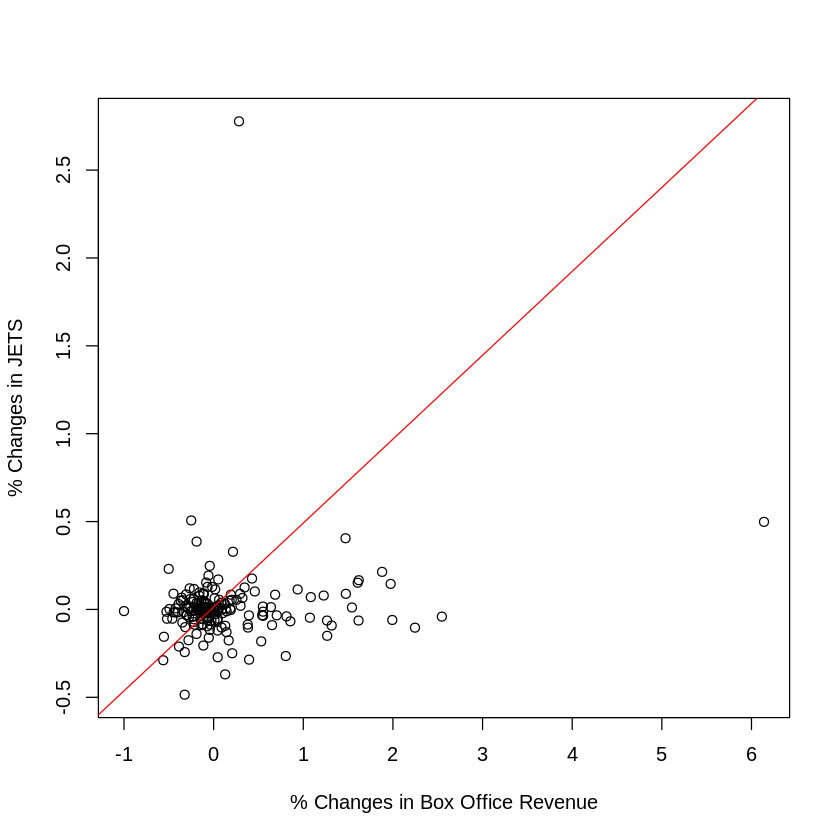

In [ ]:
lm_result_2 = lm(to_regress[,5] ~ to_regress[,3])
summary(lm_result_2)

plot(to_regress[,5] ~ to_regress[,3], xlab = "% Changes in Box Office Revenue", ylab = "% Changes in JETS")
abline(lm_result_1, col="red")

## Regressing Arithmetic Weekly JETS Return - "Improved CAPM with Box Office"

In [ ]:
lm_result_3 = lm(to_regress[,5] ~ to_regress[,6] + to_regress[,3]) #"Improved Version 1"
summary(lm_result_3)

# plot(to_regress[,5] ~ to_regress[,6] + to_regress[,3], xlab = "% Changes in SPX", ylab = "% Changes in JETS")
# abline(lm_result_1, col="red")


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6] + to_regress[, 
    3])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47004 -0.06736 -0.00560  0.04476  2.75293 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)  
(Intercept)     0.006827   0.018995   0.359   0.7197  
to_regress[, 6] 0.340962   0.626181   0.545   0.5868  
to_regress[, 3] 0.045319   0.025362   1.787   0.0757 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2448 on 172 degrees of freedom
Multiple R-squared:  0.02152,	Adjusted R-squared:  0.01015 
F-statistic: 1.892 on 2 and 172 DF,  p-value: 0.1539
